<a href="https://colab.research.google.com/github/soobook/PyTorch-DL/blob/main/code/PT12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12회차: RNN을 활용한 영화평 감성 분석 (2) - 데이터 처리 및 분석

### IMDB 영화평 감성 분석을 위한 라이브러리 로드




In [1]:
# 1. 라이브러리 불러오기
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# Keras에서 IMDB 영화 리뷰 데이터셋 모듈 로드
from keras.datasets import imdb
# Keras에서 시퀀스 데이터를 동일한 길이로 패딩해주는 함수 불러오기
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [2]:
# 2. 환경 설정: GPU 사용 가능 시 GPU 사용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on: {device}")

Running on: cpu


## IMDB 데이터 처리

In [6]:
from keras.datasets import imdb
from collections import Counter

# 데이터 로딩
# IMDB 리뷰를 이미 단어 단위로 토큰화하고 단어의 인덱스 시퀀스로 변환해 반환
(x_train, y_train), (x_test, y_test) = imdb.load_data()
# 전체 리뷰 수
print(f"학습 샘플 수: {len(x_train)}, 테스트 샘플 수: {len(x_test)}")

학습 샘플 수: 25000, 테스트 샘플 수: 25000


In [8]:
x_train[:2]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1

In [9]:
y_train[:2]

array([1, 0])

In [4]:
from collections import Counter

# 클래스 분포 확인
train_counter = Counter(y_train)
test_counter = Counter(y_test)
print("라벨 분포 (0 = 부정, 1 = 긍정):")
print(f" - 학습   데이터 분포: 0 = {train_counter[0]}, 1 = {train_counter[1]}")
print(f" - 테스트 데이터 분포: 0 = {test_counter[0]}, 1 = {test_counter[1]}")

라벨 분포 (0 = 부정, 1 = 긍정):
 - 학습   데이터 분포: 0 = 12500, 1 = 12500
 - 테스트 데이터 분포: 0 = 12500, 1 = 12500


In [5]:
# Keras에서 IMDB 영화 리뷰 데이터셋 모듈 로드
from keras.datasets import imdb

# 단어 → 정수 인덱스 사전 로드
# 단어(문자열)를 키로 하고, 해당 단어의 빈도 순 인덱스(정수)를 값으로 가지는 딕셔너리 반환
word_index = imdb.get_word_index()

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# 처음 10개 단어와 해당 인덱스를 출력
# word_index 딕셔너리에서 (k: 단어, i: 순번) 형태로 순회
for i, k in enumerate(word_index):
    if i < 10:                      # 처음 10개 항목만 출력
        print(k, word_index[k])     # 단어와 그에 해당하는 인덱스 출력

fawn 34701
tsukino 52006
nunnery 52007
sonja 16816
vani 63951
woods 1408
spiders 16115
hanging 2345
woody 2289
trawling 52008


In [7]:
# 'great'이라는 단어의 인덱스 확인
# 예: 84 → 'great'은 전체 단어 중 84번째로 자주 등장한 단어
print(word_index['great'])

84


### IMDB 데이터에서 자주 등장하는 단어 10개
- 너무 자주 나오는 단어는 관사나 의미 없는 단어일 가능성이 높음
- 감성에 영향을 미치는 단어들은 오히려 인덱스가 크고, 자주 안 나오는 단어일 수도 있음


In [8]:
from keras.datasets import imdb

# 단어 인덱스 사전 로드 (단어 → 인덱스)
word_index = imdb.get_word_index()

# 인덱스 기준으로 정렬: [(단어, 인덱스), ...]
sorted_words = sorted(word_index.items(), key=lambda x: x[1])

# 상위 10개만 출력
print("인덱스가 낮은 단어 10개:")
for word, idx in sorted_words[:10]:
    print(f"{word} : {idx}")

인덱스가 낮은 단어 10개:
the : 1
and : 2
a : 3
of : 4
to : 5
is : 6
br : 7
in : 8
it : 9
i : 10


In [9]:
import numpy as np
# Keras에서 IMDB 리뷰 데이터셋 모듈 가져오기
from keras.datasets import imdb

# IMDB 데이터셋의 단어 인덱스 사전 로딩 (단어 → 정수 인덱스)
word_index = imdb.get_word_index()
# 전체 고유 단어 수 출력 (예: 약 88,000 단어)
print(f'출현 단어 종류: {len(word_index)}')

# IMDB 데이터셋 로딩 (단어가 이미 인덱스 리스트로 변환된 상태임)
(x_train, y_train), (x_test, y_test) = imdb.load_data()
# 각 훈련 데이터(리뷰)의 단어 수를 리스트로 저장
lengths = [len(x) for x in x_train]

# 리뷰 하나당 단어 수의 최소값과 최대값 출력
print(f'리뷰당 단어수 최소: {np.min(lengths)}, 최대: {np.max(lengths)}')
# 리뷰 단어 수의 평균(mean)과 중앙값(median) 출력
print(f'리뷰당 단어수 평균: {np.mean(lengths):.2f}, 중간: {np.median(lengths)}')
# 사분위수(0%, 25%, 50%, 75%, 90%, 95%) 출력 → 데이터 분포 요약
print(f'리뷰당 단어 사분위 수: {np.percentile(lengths, [0, 25, 50, 75, 90, 95])}')

출현 단어 종류: 88584
리뷰당 단어수 최소: 11, 최대: 2494
리뷰당 단어수 평균: 238.71, 중간: 178.0
리뷰당 단어 사분위 수: [ 11. 130. 178. 291. 467. 610.]


### 워드 인덱스(단어 → 인덱스)에서 새로운 단어 사전(인덱스 → 단어) 생성
- IMDB 데이터셋에서 정수 인덱스를 단어로 복원할 수 있도록 "역방향 사전(reverse dictionary)“ 생성
  - 원래 IMDB 단어 인덱스는 0~3번이 비어 있음 → 특수 토큰용
  - 모든 단어 인덱스를 3만큼 밀어서 충돌을 방지
  - 단어 → 인덱스 사전을 인덱스 → 단어 사전으로 뒤집어 reverse_word_index에 저장


In [10]:
from keras.datasets import imdb

# 1. 단어 인덱스 사전 불러오기
word_index = imdb.get_word_index()
# Keras 내부 offset 반영
# {단어: 인덱스, ...} -> {인덱스+3: 단어}로 변환
reverse_word_index = {v + 3: k for k, v in word_index.items()}
reverse_word_index[0] = "<PAD>"
reverse_word_index[1] = "<START>"
reverse_word_index[2] = "<UNK>"
reverse_word_index[3] = "<UNUSED>"

# 2. 데이터셋 로드 (전체 단어 포함)
(x_train, y_train), (x_test, y_test) = imdb.load_data()

# 3. 첫 번째 리뷰 선택
sample = x_train[0]
print(f'첫 리뷰의 단어 수: {len(sample)}')
print(f'첫 리뷰 앞 10개:\n {sample[:10]}')
print(f'첫 리뷰 뒤 10개:\n {sample[-10:]}')

# 4. 워드 인덱스와 해당 단어 함께 출력
print("첫 번째 리뷰: 워드 인덱스와 단어 매핑\n")
for idx in sample[:10]:
    # 모르는 인덱스는 ?로 표시
    word = reverse_word_index.get(idx, "?")
    print(f"{idx:<6} → {word}")

첫 리뷰의 단어 수: 218
첫 리뷰 앞 10개:
 [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
첫 리뷰 뒤 10개:
 [4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
첫 번째 리뷰: 워드 인덱스와 단어 매핑

1      → <START>
14     → this
22     → film
16     → was
43     → just
530    → brilliant
973    → casting
1622   → location
1385   → scenery
65     → story


### 자연어 처리 주요 하이퍼파라미터를 변수에 설정
- vocab_size: 중요한(자주 등장하는) 단어 몇 개를 유지
	- 전체 단어 중 출현 빈도 상위 10,000개 단어만 사용
	- 나머지 단어는 <UNK>(인덱스 2, <unk>)로 처리
- max_len: 리뷰 당 길이를 제한, 패딩 또는 자름
	- 모든 리뷰의 길이를 500으로 고정→ 짧으면 기본적으로 앞부터 0으로 채우고, 길면 자름
	- 한 영화평 리뷰의 단어 수 평균: 약 238개 정도, 90% 467, 95% 610




In [11]:
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

# 3. 데이터 로딩 및 전처리
# 등장 빈도 순으로 상위 10,000개 단어만 사용 (나머지는 <UNK> 처리됨)
vocab_size = 10000  # 빈도 상위 10,000개의 단어만 사용, 총 단어 88584
max_len = 500       # 모든 리뷰를 길이 500으로 패딩 또는 자름

# IMDB 데이터셋 로딩 (이미 토큰화 되어 있음)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

print(x_train.shape, x_test.shape)
print(f'첫 리뷰의 단어 수: {len(x_train[0])}')

(25000,) (25000,)
첫 리뷰의 단어 수: 218


In [12]:
# 리뷰 길이 맞추기 (길이 부족한 건 0으로 채움)
# 길이가 길면 기본값(truncating='pre')은 앞을 자름
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
print('패딩 후 2차원 모양: ', x_train.shape, x_test.shape)
print(f'첫 리뷰의 패딩된 첫 10개 단어: {x_train[0][:10]}')
print(f'첫 리뷰의 패딩된 마지막 10개 단어: {x_train[0][-10:]}')

패딩 후 2차원 모양:  (25000, 500) (25000, 500)
첫 리뷰의 패딩된 첫 10개 단어: [0 0 0 0 0 0 0 0 0 0]
첫 리뷰의 패딩된 마지막 10개 단어: [4472  113  103   32   15   16 5345   19  178   32]


## 텍스트 데이터 분석: 단어 임베딩

In [13]:
!pip show gensim

### 다음 라이브러리 gensim 설치 시
- 마지막에 표시되는 다음 대화상자에서 "세션 다시 시작" 클릭

 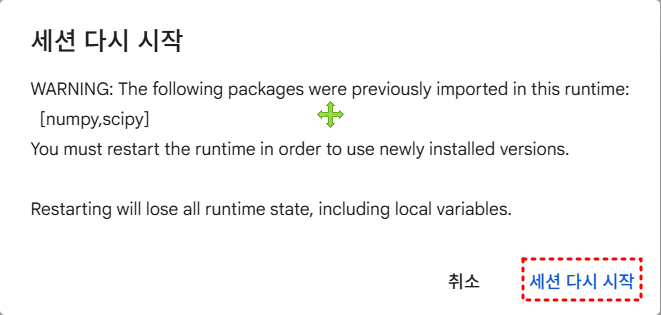

In [14]:
# 처음 실행 시 마지막에 오류나면 다시 한번 실행해 보기
!pip install gensim==4.3.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 16.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tsfr

In [ ]:
# !pip install -U gensim # 최신 버전 설치 명령

### Word2Vec 주요 파라미터
| **파라미터**        | **기본값**  | **설명**                           |
| --------------- | -------- | -------------------------------- |
| **sentences**   | 필수       | 학습에 사용할 문장 리스트 (토큰화된 형태)         |
| **vector_size** | 100      | 단어 임베딩 차원 수 (예: 100, 200, 300)   |
| **window**      | 5        | 중심 단어 기준으로 앞뒤 몇 개 단어를 문맥 범위로 간주  |
| **min_count**   | 5        | 최소 몇 번 이상 등장한 단어만 학습에 사용         |
| **workers**     | 3        | 학습에 사용할 스레드 수 (병렬 처리용)           |
| **sg**          | 0 (CBOW) | 학습 알고리즘: 0 = CBOW, 1 = Skip-gram |
| **epochs**      | 5        | 전체 데이터셋을 반복해서 학습하는 횟수            |
| **seed**        | None     | 랜덤 초기화 고정용 (재현 가능성 위해 설정 가능)     |


In [2]:
import numpy as np
from gensim.models import Word2Vec

# 샘플 문장들 (토큰화된 형태로 입력되어야 함)
sentences = [
    ["i", "love", "machine", "learning"],
    ["deep", "learning", "is", "a", "subset", "of", "machine", "learning"],
    ["word", "embedding", "maps", "words", "to", "vectors"],
    ["i", "love", "deep", "learning"],
    ["natural", "language", "processing", "is", "fun"]
]

# Word2Vec 모델 학습
model = Word2Vec(sentences, vector_size=10, window=3,
                 min_count=1, sg=1, epochs=100, seed=50)

# word에 저장된 단어의 임베딩 벡터 출력 (10차원)
word = 'machine'
print(f"Vector for '{word}':")
print(model.wv[word].shape)
np.set_printoptions(precision=2)
print(model.wv[word])

# word에 저장된 단어와 가장 유사한 단어 3개 출력
print(f"Top 3 similar words to '{word}':")
# 일반적으로 0.7 이상의 점수는 높은 유사성을, 0.3 미만의 점수는 낮은 유사성
print(model.wv.most_similar(word, topn=3))

Vector for 'machine':
(10,)
[-0.04  0.1   0.01  0.02 -0.01  0.08  0.01 -0.1   0.06  0.02]
Top 3 similar words to 'machine':
[('love', 0.5026947259902954), ('to', 0.4828498959541321), ('deep', 0.371460497379303)]


In [3]:
!pip install koreanize-matplotlib
import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 43.5 MB/s eta 0:00:00


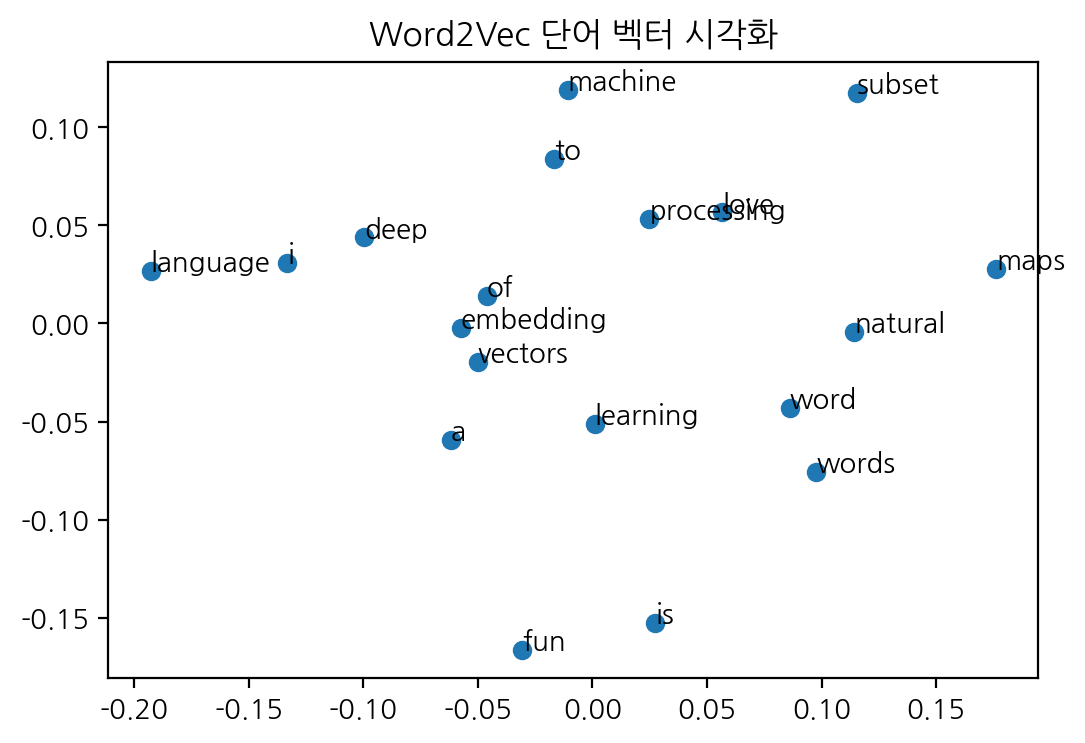

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

words = list(model.wv.index_to_key)
X = model.wv[words]
X_reduced = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(6, 4))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])

for i, word in enumerate(words):
    plt.annotate(word, xy=(X_reduced[i, 0], X_reduced[i, 1]))

plt.title("Word2Vec 단어 벡터 시각화")
plt.show()

## 학습 종료

### 심화 학습

In [ ]:
# 1. Word2Vec 사전학습 벡터 로드 (Google News, 300차원)
import time
import gensim.downloader as api

start = time.time()
print("모델 다운로드 중 (잠시 시간 걸림)...")
model = api.load("word2vec-google-news-300")  # 1.5GB 정도
print("모델 로딩 완료!")
end = time.time()
print(f"실행 시간: {end - start:.2f}초")

# 2. 단어 벡터 연산
result = model.most_similar(positive=['king', 'woman'], negative=['man'], topn=5)

print("\n'king' - 'man' + 'woman' ≈ ???")
for word, score in result:
    print(f"{word:<10}  (similarity: {score:.4f})")

모델 다운로드 중 (잠시 시간 걸림)...
모델 로딩 완료!
실행 시간: 69.40초

'king' - 'man' + 'woman' ≈ ???
queen       (similarity: 0.7118)
monarch     (similarity: 0.6190)
princess    (similarity: 0.5902)
crown_prince  (similarity: 0.5499)
prince      (similarity: 0.5377)


## 종료